# BatchedMELBO Performance

The goal of this notebook is to demonstrate the speed of training. We compare 3 training runs:
1. Using the original method..
2. Using BatchedMELBO.
3. [Bonus] Using BatchedMELBO with bf16.

We will train 256 vectors for 3 steps on 2 prompts on Qwen2.5-3B model using an RTX 5090 GPU.

In [1]:
MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"
TOKENIZER_NAME = "Qwen/Qwen2.5-3B-Instruct" 

SOURCE_LAYER = 8
TARGET_LAYER = 16
NORMALIZATION = 4.0
TOKEN_IDXS = slice(-3,None)
POWER = 2
POWERQ = 1
NUM_STEPS = 3
NUM_VECTORS = 256

EXAMPLES = [\
'''<|system|>
You are a helpful assistant

<|user|>
a=5+6, b=7+2. What is a*b?

<|assistant|>
''', '''<|system|>
You are a helpful assistant

<|user|>
What is the capital of France?

<|assistant|>
''']

# Original

In [2]:
%%time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import time
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto")

/workspace/batched_melbo/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


CPU times: user 9.08 s, sys: 1.07 s, total: 10.1 s
Wall time: 4.7 s


In [3]:
tokenizer.padding_side = "left"
tokenizer.pad_token_id

151643

In [4]:
import sys
sys.path.append("../src")
from original_melbo import SteeredModel

original_method = SteeredModel(
    model,
    tokenizer,
    source_layer_idx = SOURCE_LAYER,
    target_layer_idx = TARGET_LAYER,
    target_token_idxs = TOKEN_IDXS,
    normalization = NORMALIZATION,
    orthogonal_vectors = False,
    num_steps = NUM_STEPS,
    power = POWER,
    q = POWERQ,
    layers_name = "model.layers"
)


In [5]:
%%time

start_time = time.time()
original_method.train(EXAMPLES, NUM_VECTORS)
end_time = time.time()

original_duration = end_time - start_time

100%|██████████| 256/256 [00:58<00:00,  4.35it/s]

CPU times: user 58.8 s, sys: 355 ms, total: 59.2 s
Wall time: 59.1 s


# BatchedMELBO

In [6]:
%%time
from batched_melbo import BatchedMELBO

batched_melbo = BatchedMELBO(
    model,
    tokenizer,
    source_layer_idx = SOURCE_LAYER,
    target_layer_idx = TARGET_LAYER,
    target_token_idxs = TOKEN_IDXS,
    normalization = NORMALIZATION,
    num_steps = NUM_STEPS,
    power = POWER,
    q = POWERQ,
    layers_name = "model.layers"
)

CPU times: user 6.87 ms, sys: 3.97 ms, total: 10.8 ms
Wall time: 10.2 ms


In [7]:
%%time

start_time = time.time()
batched_melbo.train(EXAMPLES, NUM_VECTORS, vector_batch_size=64)
end_time = time.time()

batched_melbo_duration = end_time - start_time

Training batch 1 of 4:   0%|          | 0/3 [00:00<?, ?it/s]

Training batch 4 of 4: 100%|██████████| 3/3 [00:00<00:00,  3.57it/s]

CPU times: user 2.77 s, sys: 548 ms, total: 3.32 s
Wall time: 3.31 s


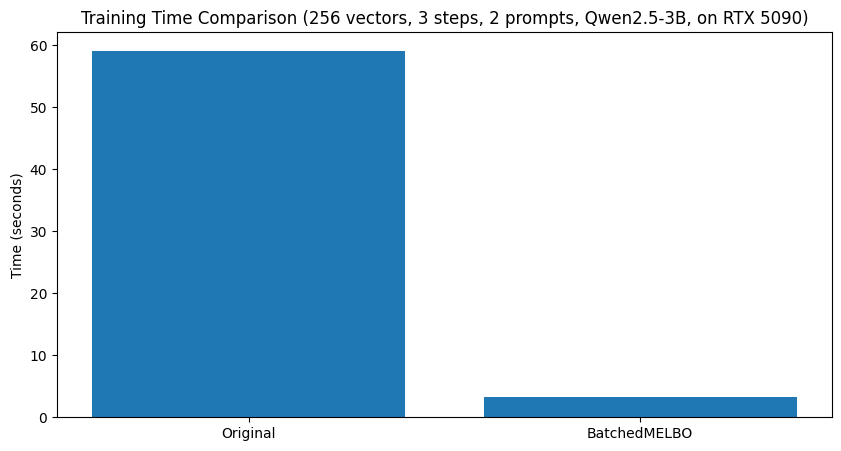

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(['Original', 'BatchedMELBO'], [original_duration, batched_melbo_duration])
plt.ylabel('Time (seconds)')
plt.title('Training Time Comparison (256 vectors, 3 steps, 2 prompts, Qwen2.5-3B, on RTX 5090)')
plt.show()

In [9]:
print(f"Speedup: {(original_duration / batched_melbo_duration):.1f}x")

Speedup: 17.9x


# Bonus: more juice by enabling mixed-precision training

Support for mixed-precision training has been added to BatchedMELBO, so vectors can be trained in bf16 by loading your model in half-precision. This gives an extra 2x to 3x boost to training speed.

In [10]:
del model, original_method, batched_melbo
import gc
gc.collect()
torch.cuda.empty_cache()

In [11]:
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto", dtype=torch.bfloat16)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


In [12]:
batched_melbo_bf16 = BatchedMELBO(
    model,
    tokenizer,
    source_layer_idx = SOURCE_LAYER,
    target_layer_idx = TARGET_LAYER,
    target_token_idxs = TOKEN_IDXS,
    normalization = NORMALIZATION,
    num_steps = NUM_STEPS,
    power = POWER,
    q = POWERQ,
    layers_name = "model.layers"
)

In [13]:
%%time

start_time = time.time()
batched_melbo_bf16.train(EXAMPLES, NUM_VECTORS, vector_batch_size=128)
end_time = time.time()

batched_melbo_bf16_duration = end_time - start_time

Training batch 2 of 2: 100%|██████████| 3/3 [00:00<00:00,  5.20it/s]

CPU times: user 871 ms, sys: 359 ms, total: 1.23 s
Wall time: 1.23 s


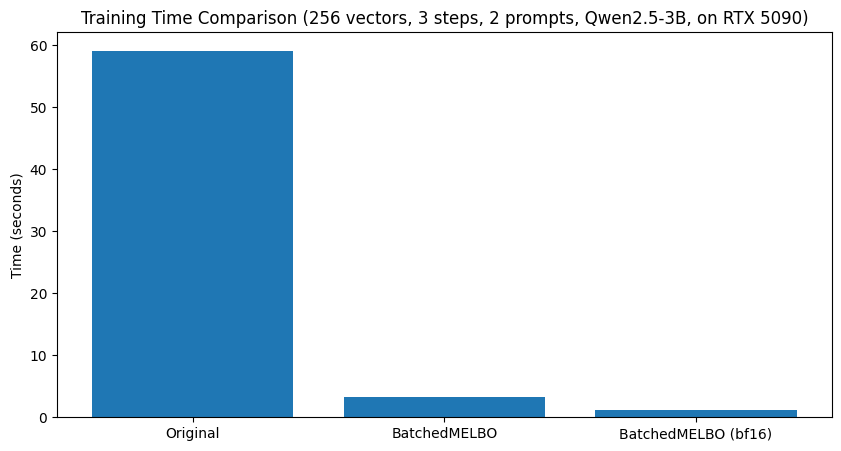

In [15]:
plt.figure(figsize=(10, 5))
plt.bar(['Original', 'BatchedMELBO', 'BatchedMELBO (bf16)'], [original_duration, batched_melbo_duration, batched_melbo_bf16_duration])
plt.ylabel('Time (seconds)')
plt.title('Training Time Comparison (256 vectors, 3 steps, 2 prompts, Qwen2.5-3B, on RTX 5090)')
# plt.yscale('log')
plt.show()